# Package and functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime


In [5]:
def call_price(S_t,K,sigma,r,T,t):
  '''
  Theoritical value of the European call option
  '''
  d_1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
  d_2 = d_1 - sigma*np.sqrt(T-t)
  return S_t*norm.cdf(d_1) - K*np.exp(-r*(T-t))*norm.cdf(d_2) #,d_1,d_2

In [6]:
def dig_call(S_t,K,sigma,r,T,t):
  d_1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
  d_2 = d_1 - sigma*np.sqrt(T-t)
  return np.exp(-r*T) * norm.cdf(d_2)

In [7]:
# By put call parity
def put_price(S_t,K,sigma,r,T,t):
  '''
  Theoritical value of the European put option
  By put call parity
  '''
  return call_price(S_t,K,sigma,r,T,t)-S_t+K*np.exp(-r*(T-t)) #,d_1,d_2

# By BS formula
def BS_put(S_t,K,sigma,r,T,t):
  '''
  Theoritical value of the European put option
  By BS formula
  '''
  d_1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
  d_2 = d_1 - sigma*np.sqrt(T-t)
  return np.exp(-r*(T-t))*K*norm.cdf(-d_2)-S_t*norm.cdf(-d_1)


In [8]:
def dig_put(S_t,K,sigma,r,T,t):
    d_1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    d_2 = d_1 - sigma*np.sqrt(T-t)
    return np.exp(-r*T) * norm.cdf(-d_2)

In [9]:
def stock_sim(S_0,mu,sigma,T,n,N):
  '''

  S_0: initial stock price
  mu: drift rate
  sigma: volatility of stock
  T: maturity date
  n: number of steps(dt = T/n)
  N: number of simulations


  return: S a N by n+1 matrix. Each row is a stock path.
  '''
  dW = np.random.normal(0, np.sqrt(T/n), [N,n])
  S = np.zeros([N,n+1])
  S[:,0] = [S_0]*N
  for i in range(n):
      S[:,i+1] = S[:,i] +mu*S[:,i]*T/n +sigma * S[:,i] * dW[:,i]
  return S

# Theoretical

## very high upper barrier (institution's value)

In [10]:
S_0 =50
K = S_0
L = 35
sigma = 0.55
r = 0.04
T = 1
k_1 = r/(0.5*sigma**2)
M = 1
y=0.18

In [11]:
# Value of the down-and-in put at t0
v_p = put_price(S_0,L,sigma,r,T,0)+dig_put(S_0,L,sigma,r,T,0)*(K-L) + (L/S_0)**(k_1-1)*(put_price(L**2/S_0,K,sigma,r,T,0)-put_price(L**2/S_0,L,sigma,r,T,0)-dig_put(L**2/S_0,L,sigma,r,T,0)*(K-L))
v_p


9.211493864826227

In [12]:
# Value of the down-and-out digital put at t0
v_d = np.exp(-r*T)- dig_put(S_0,L,sigma,r,T,0) - (L/S_0)**(k_1-1)*(np.exp(-r*T) - dig_put(L**2/S_0,L,sigma,r,T,0))
v_d

0.39930936583412874

In [13]:
# Value of interest profit at t0
v_i = M*(1-np.exp(-r*T))
v_i

0.03921056084767682

In [14]:
V = M/S_0 * v_p - y*T*M*v_d +v_i
V

0.1515647522940582

In [15]:
# this version uses yTM as coupon
def theo_high_upper(S_0,L, sigma, r,T,M,y):
  K = S_0
  k_1 = r/(0.5*sigma**2)
  v_p = put_price(S_0,L,sigma,r,T,0)+dig_put(S_0,L,sigma,r,T,0)*(K-L) + (L/S_0)**(k_1-1)*(put_price(L**2/S_0,K,sigma,r,T,0)-put_price(L**2/S_0,L,sigma,r,T,0)-dig_put(L**2/S_0,L,sigma,r,T,0)*(K-L))
  v_d = np.exp(-r*T)- dig_put(S_0,L,sigma,r,T,0) - (L/S_0)**(k_1-1)*(np.exp(-r*T) - dig_put(L**2/S_0,L,sigma,r,T,0))
  v_i = M*(1-np.exp(-r*T))
  V = M/S_0 * v_p - y*T*M*v_d +v_i
  return V

In [25]:
# this version uses (exp(yT)-1)M as coupon
def theo_high_upper(S_0,L, sigma, r,T,M,y):
  K = S_0
  k_1 = r/(0.5*sigma**2)
  v_p = put_price(S_0,L,sigma,r,T,0)+dig_put(S_0,L,sigma,r,T,0)*(K-L) + (L/S_0)**(k_1-1)*(put_price(L**2/S_0,K,sigma,r,T,0)-put_price(L**2/S_0,L,sigma,r,T,0)-dig_put(L**2/S_0,L,sigma,r,T,0)*(K-L))
  v_d = np.exp(-r*T)- dig_put(S_0,L,sigma,r,T,0) - (L/S_0)**(k_1-1)*(np.exp(-r*T) - dig_put(L**2/S_0,L,sigma,r,T,0))
  v_i = M*(1-np.exp(-r*T))
  V = M/S_0 * v_p - (np.exp(y*T)-1)*M*v_d +v_i
  return V

# Simulation

In [17]:
# This function returns the value for the client by simulation
def simulation_snowball(n,N,S_0, sigma,T,r,H,L,M,y):
    mu = r
    stock_path= stock_sim(S_0,mu,sigma,T,n,N)
    path_df = pd.DataFrame(stock_path)
    # find the knock-out date index, index of tau
    knock_out = (path_df>H).idxmax(axis =1 )
    # calculate the tau in years
    tau = knock_out[knock_out !=0] /n*T
    dis_payoff_out = M*(np.exp((y-r)*tau) -1 )

    # find no knock-in and no knock-out paths
    no_in_no_out = (~(((path_df<=L).any(axis=1))|((path_df>=H).any(axis=1)))).astype(int)
    dis_payoff_no_event = M*(np.exp((y-r)*T)-1)*no_in_no_out[no_in_no_out ==1]


    # find knock in and no knock out paths
    knock_in = path_df[((path_df<L).any(axis=1))&((path_df<H).all(axis=1))].iloc[:,-1]
    dis_payoff_in = -M/S_0 * knock_in.apply(lambda x: 0 if x>S_0 else S_0-x) *np.exp(-r*T) - M*(1-np.exp(-r*T))

    price = (dis_payoff_out.sum()+dis_payoff_no_event.sum()+dis_payoff_in.sum())/N
    return price

In [85]:
S_0 = 50
sigma = 0.55
r = 0.04
T = 1
mu = r
n = 252
N = 1000
L = 0.7 * S_0
#L = 0
H = 1.05 *S_0
y = 0.18
#H = np.inf

In [19]:
average = 0
for i in range(1000):
  average += simulation_snowball(252, 1000, S_0, sigma,T,r,H,L,M,y)
average/1000

-0.046507607279306314

In [87]:
n_list = [i for i in range(250, 1251,250)]
N_list = [i for i in range(1000,9001,2000)] + [10000]
result = {key:[] for key in n_list}
for n in n_list:
  for N in N_list:
    result[n].append(simulation_snowball(n,N, S_0, sigma,T,r,H,L,M,y))

pd.DataFrame(result, index = N_list)
# index: number of paths simulated
# column: number of discrete steps in each path

,250,500,750,1000,1250
1000,-0.045119,-0.038274,-0.033153,-0.035135,-0.043334
3000,-0.044054,-0.046672,-0.042411,-0.040682,-0.040724
5000,-0.048666,-0.043173,-0.042657,-0.041954,-0.037184
7000,-0.047973,-0.043576,-0.038955,-0.037028,-0.040271
9000,-0.046498,-0.044448,-0.044708,-0.041561,-0.043218
10000,-0.045155,-0.040312,-0.039705,-0.039881,-0.035868


In [30]:
S_0 = 50
sigma = 0.55
r = 0.04
T = 1
mu = r
n = 252
N = 1000
L = 0.9 * S_0
H = 1.8 *S_0
y = 0.18
n_list = [i for i in range(250, 1251,250)]
N_list = [i for i in range(1000,9001,2000)] + [10000]
result = {key:[] for key in n_list}
for n in n_list:
  for N in N_list:
    result[n].append(simulation_snowball(n,N, S_0, sigma,T,r,H,L,M,y))

pd.DataFrame(result, index = N_list)
# index: number of paths simulated
# colum: number of discrete steps in each path

,250,500,750,1000,1250
1000,-0.181045,-0.196633,-0.200190,-0.205104,-0.196069
3000,-0.195225,-0.192447,-0.197709,-0.194507,-0.200843
5000,-0.198246,-0.193237,-0.194728,-0.193491,-0.203341
7000,-0.197493,-0.197261,-0.193954,-0.196415,-0.198527
9000,-0.200617,-0.198370,-0.193799,-0.196628,-0.200898
10000,-0.200669,-0.197886,-0.200132,-0.195735,-0.202174


## Compare Analytical and Simulation resutls: Client's View

### Low Volatility

In [ ]:
# Low volatility: Client's View
S_0 = 50
sigma = 0.00001
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05 * S_0
y = 0.18
print('Theoretical: ', M*((np.exp(y-r)*T)-1))
print('Simulation: ', simulation_snowball(252,10000,S_0, sigma,T,r,H,L,M,y))

Theoretical:  0.15027379885722736
Simulation:  0.15027379885722736


### High Upper Barrier

In [51]:
# High Upper Barrier
S_0 = 50
sigma = 10
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = np.inf
y = 0.18
print('Theoretical: ', -theo_high_upper(S_0,L,sigma,r,T,M,y)) # negative since we want clients view
print('Simulation: ', simulation_snowball(25200,1000,S_0, sigma,T,r,H,L,M,y))

Theoretical:  -0.9999994371635652
Simulation:  -0.9999999996725469


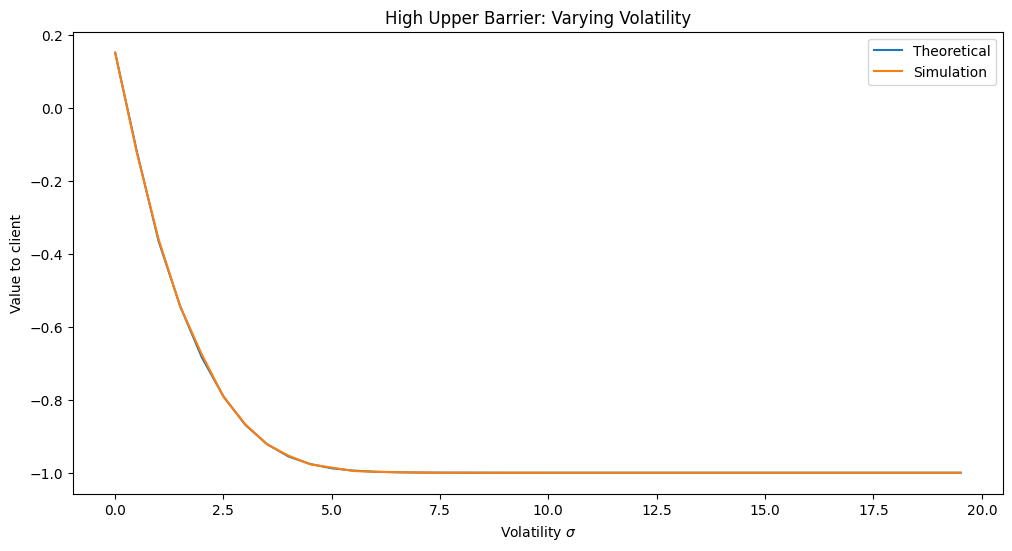

In [77]:
# High Upper Barrier with varying sigma
S_0 = 50
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = np.inf
y = 0.18
sig_list = np.arange(0.01,20,0.5)
theo_list = []
sim_list = []
for sig in sig_list:
  theo_list.append(-theo_high_upper(S_0,L,sig,r,T,M,y))
  sim_list.append(simulation_snowball(2520,5000,S_0, sig,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(sig_list, theo_list, label= 'Theoretical')
plt.plot(sig_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('Volatility $\sigma$')
plt.title('High Upper Barrier: Varying Volatility')
plt.show()

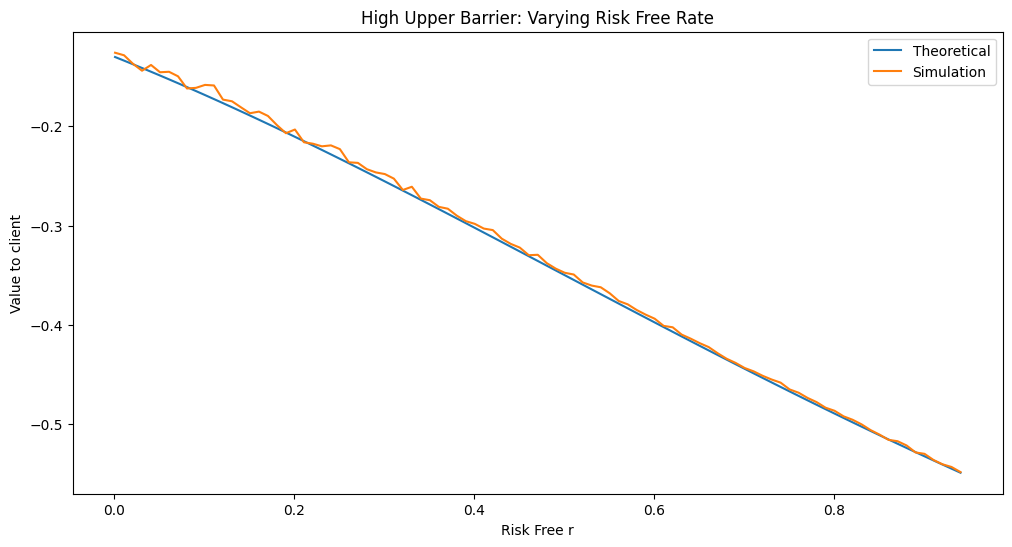

In [ ]:
# High Upper Barrier with varying r
S_0 = 50
sigma = 0.55
T = 1
M = 1
L = 0.7 * S_0
H = np.inf
y = 0.18
r_list = np.arange(0.001,0.95,0.01)
theo_list = []
sim_list = []
for r in r_list:
  theo_list.append(-theo_high_upper(S_0,L,sigma,r,T,M,y))
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(r_list, theo_list, label= 'Theoretical')
plt.plot(r_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('Risk Free r')
plt.title('High Upper Barrier: Varying Risk Free Rate')
plt.show()

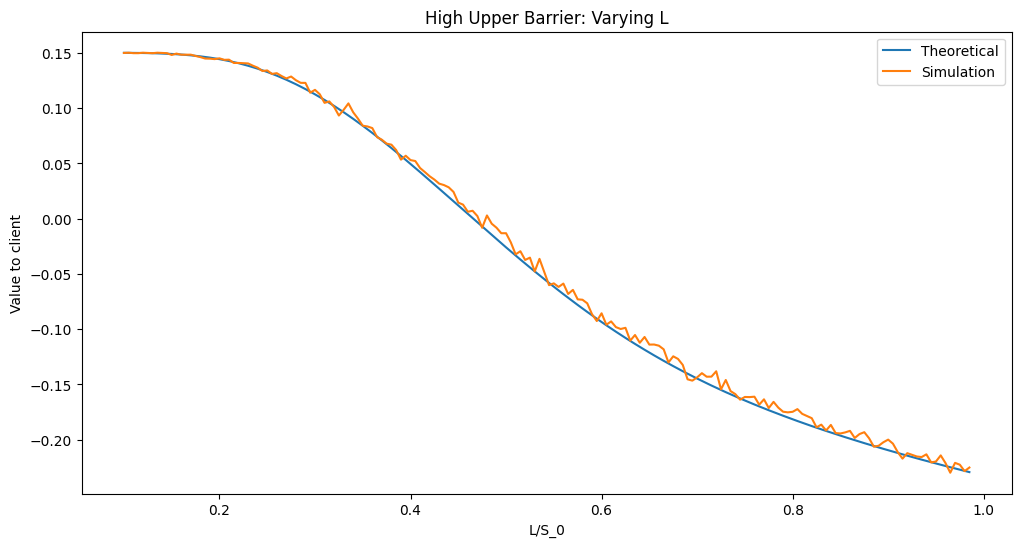

In [ ]:
# High Upper Barrier with varying L
S_0 = 50
sigma = 0.55
T = 1
M = 1
H = np.inf
y = 0.18
r = 0.04
coef_list = np.arange(0.1,0.99,0.005)
theo_list = []
sim_list = []

for coef in coef_list:
  L =  coef * S_0
  theo_list.append(-theo_high_upper(S_0,L,sigma,r,T,M,y))
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(coef_list, theo_list, label= 'Theoretical')
plt.plot(coef_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('L/S_0')
plt.title('High Upper Barrier: Varying L')
plt.show()

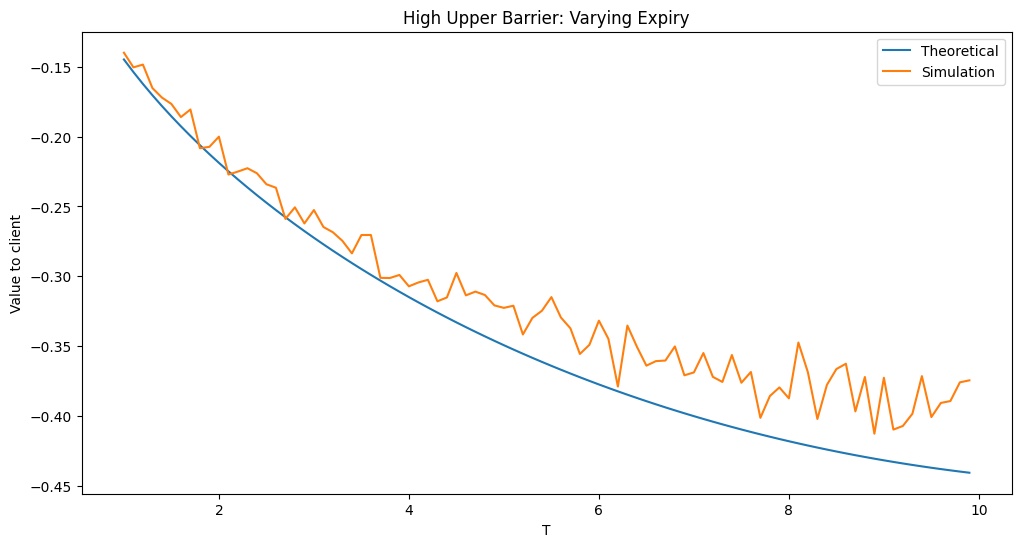

In [ ]:
# High Upper Barrier with varying T
S_0 = 50
sigma = 0.55
M = 1
L =  0.7 * S_0
H = np.inf
y = 0.18
r = 0.04
T_list = np.arange(1,10,0.1)
theo_list = []
sim_list = []

for T in T_list:
  theo_list.append(-theo_high_upper(S_0,L,sigma,r,T,M,y))
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(T_list, theo_list, label= 'Theoretical')
plt.plot(T_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('T')
plt.title('High Upper Barrier: Varying Expiry')
plt.show()

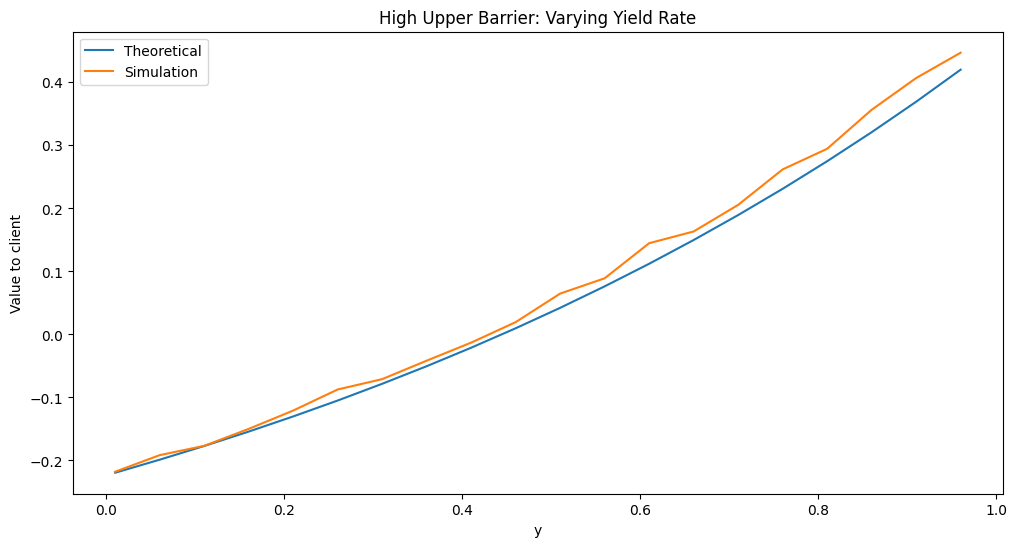

In [ ]:
# High Upper Barrier with varying y
S_0 = 50
sigma = 0.55
M = 1
T =1
L =  0.7 * S_0
H = np.inf
r = 0.04
y_list = np.arange(0.01,0.99,0.05)
theo_list = []
sim_list = []

for y in y_list:
  theo_list.append(-theo_high_upper(S_0,L,sigma,r,T,M,y))
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(y_list, theo_list, label= 'Theoretical')
plt.plot(y_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('y')
plt.title('High Upper Barrier: Varying Yield Rate')
plt.show()

### Normal Case

In [ ]:
S_0 = 50
sigma = 0.001
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05* S_0
y = 0.18
print('Simulation: ', simulation_snowball(252,10000,S_0, sigma,T,r,H,L,M,y))

Simulation:  0.15027379885722736


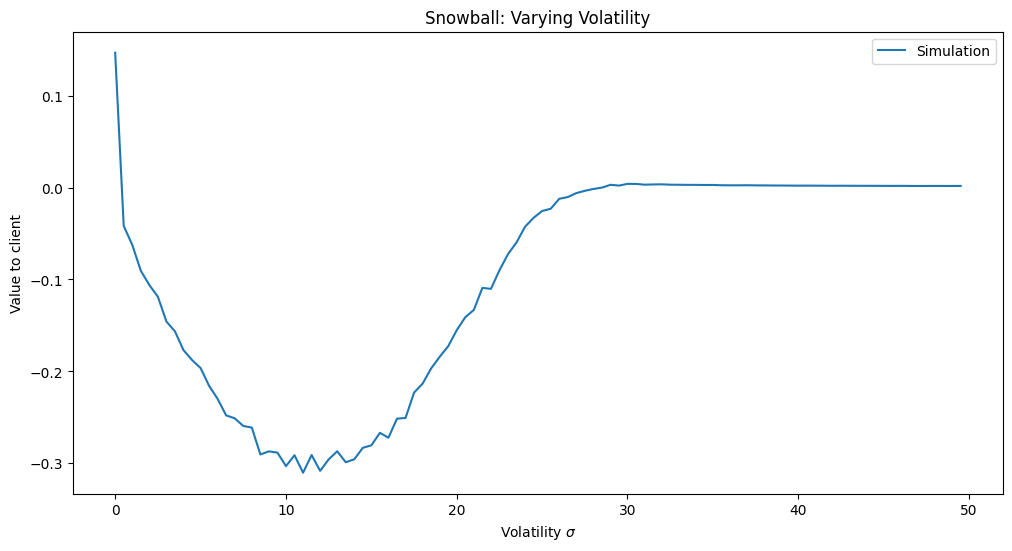

In [75]:
# Normal Case with varying sigma
S_0 = 50
r = 0.04
T = 1
M = 1
L = 0.7 * S_0
H = 1.05 *S_0
y = 0.18
mu = r

sig_list = np.arange(0.01,50,0.5)
theo_list = []
sim_list = []
for sig in sig_list:
  theo_list.append(-theo_high_upper(S_0,L,sig,r,T,M,y))
  sim_list.append(simulation_snowball(2520,5000,S_0, sig,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(sig_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('Volatility $\sigma$')
plt.title('Snowball: Varying Volatility')
plt.show()

In [63]:
# Normal Case with varying sigma
S_0 = 50
r = 0.04
T = 1
M = 1
L = 0.7 * S_0
H = 1.05 *S_0
y = 0.18
sig_list = np.arange(0.001,100,0.5)
sim_list_252  = []
sim_list_1260 = []
sim_list_2520 = []
sim_list_5040 = []
for sig in sig_list:
  sim_list_252.append(simulation_snowball(252,2000,S_0, sig,T,r,H,L,M,y))
  sim_list_1260.append(simulation_snowball(1260,2000,S_0, sig,T,r,H,L,M,y))
  sim_list_2520.append(simulation_snowball(2520,2000,S_0, sig,T,r,H,L,M,y))
  sim_list_5040.append(simulation_snowball(5040,2000,S_0, sig,T,r,H,L,M,y))


<ipython-input-9-80763ea03db9>:18: RuntimeWarning: overflow encountered in multiply
  S[:,i+1] = S[:,i] +mu*S[:,i]*T/n +sigma * S[:,i] * dW[:,i]
<ipython-input-9-80763ea03db9>:18: RuntimeWarning: invalid value encountered in add
  S[:,i+1] = S[:,i] +mu*S[:,i]*T/n +sigma * S[:,i] * dW[:,i]
<ipython-input-9-80763ea03db9>:18: RuntimeWarning: overflow encountered in multiply
  S[:,i+1] = S[:,i] +mu*S[:,i]*T/n +sigma * S[:,i] * dW[:,i]
<ipython-input-9-80763ea03db9>:18: RuntimeWarning: invalid value encountered in add
  S[:,i+1] = S[:,i] +mu*S[:,i]*T/n +sigma * S[:,i] * dW[:,i]


"\nplt.figure(figsize=(12,6))\nplt.plot(sig_list, sim_list, label = 'Simulation')\nplt.legend()\nplt.ylabel('Value to client')\nplt.xlabel('Volatility $\\sigma$')\nplt.title('Snowball: Varying Volatility')\nplt.show()\n"

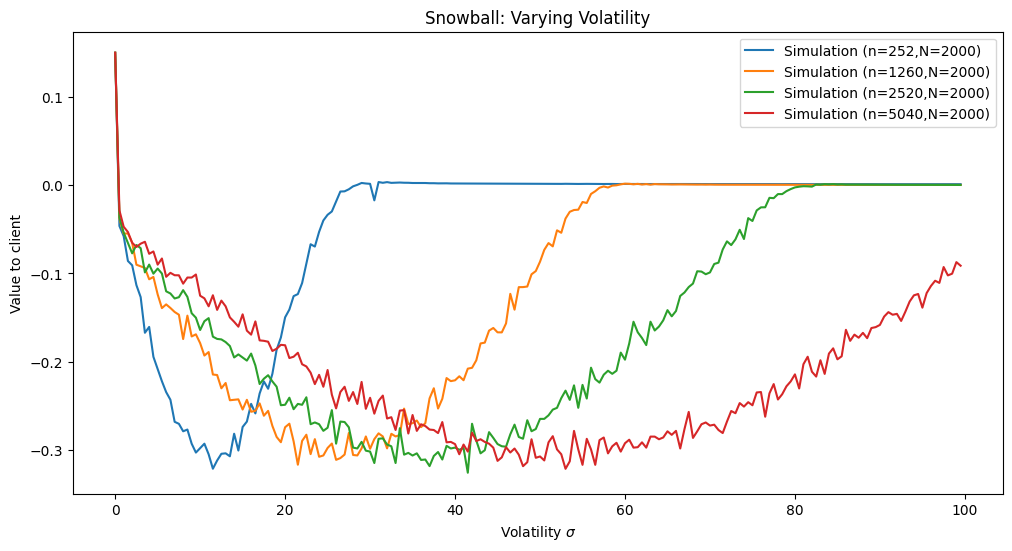

In [64]:
plt.figure(figsize=(12,6))
plt.plot(sig_list, sim_list_252, label = 'Simulation (n=252,N=2000)')
plt.plot(sig_list, sim_list_1260, label = 'Simulation (n=1260,N=2000)')
plt.plot(sig_list, sim_list_2520, label = 'Simulation (n=2520,N=2000)')
plt.plot(sig_list, sim_list_5040, label = 'Simulation (n=5040,N=2000)')

plt.legend()
plt.ylabel('Value to client')
plt.xlabel('Volatility $\sigma$')
plt.title('Snowball: Varying Volatility')
plt.show()

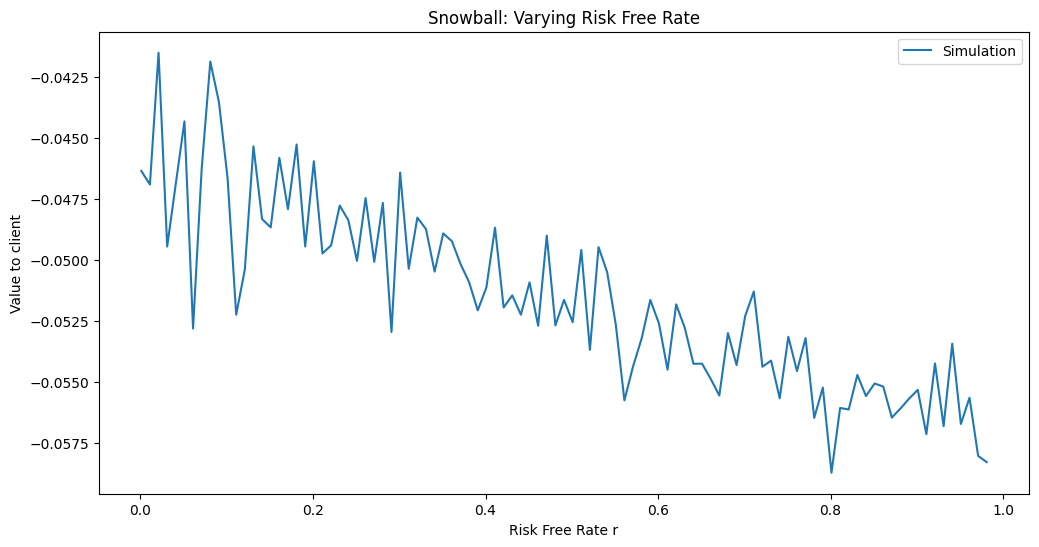

In [ ]:
# Normal Case with varying interest rate r
S_0 = 50
sigma= 0.55
T = 1
M = 1
L = 0.7 * S_0
H = 1.05 *S_0
y = 0.18
r_list = np.arange(0.001,0.99,0.01)
sim_list = []
for r in r_list:
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(r_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('Risk Free Rate r')
plt.title('Snowball: Varying Risk Free Rate')
plt.show()

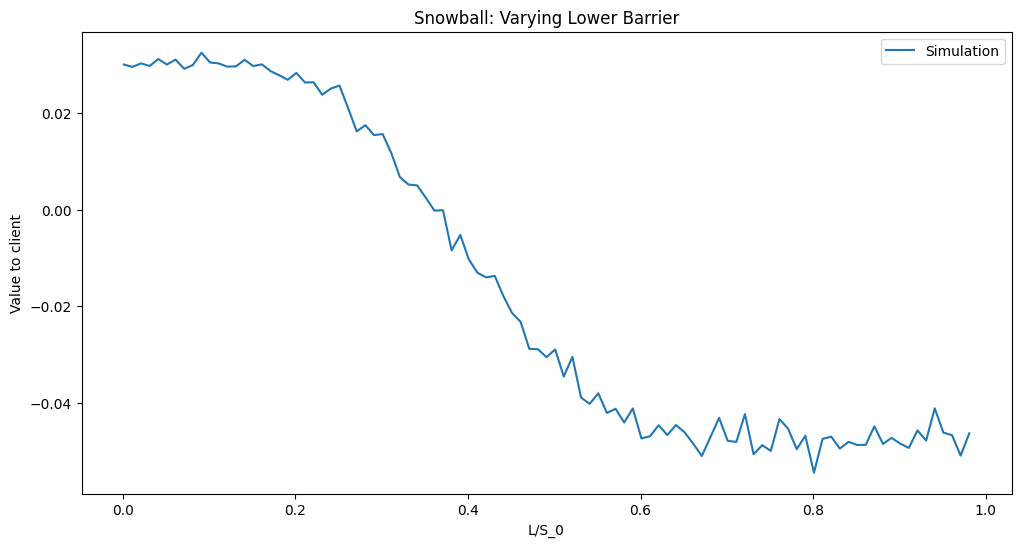

In [ ]:
# Normal Case with varying Lower Barrier L
S_0 = 50
sigma= 0.55
r = 0.04
T = 1
M = 1
H = 1.05 *S_0
y = 0.18
coef_list = np.arange(0.001,0.99,0.01)
sim_list = []
for coef in coef_list:
  L = coef * S_0
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(coef_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('L/S_0')
plt.title('Snowball: Varying Lower Barrier')
plt.show()

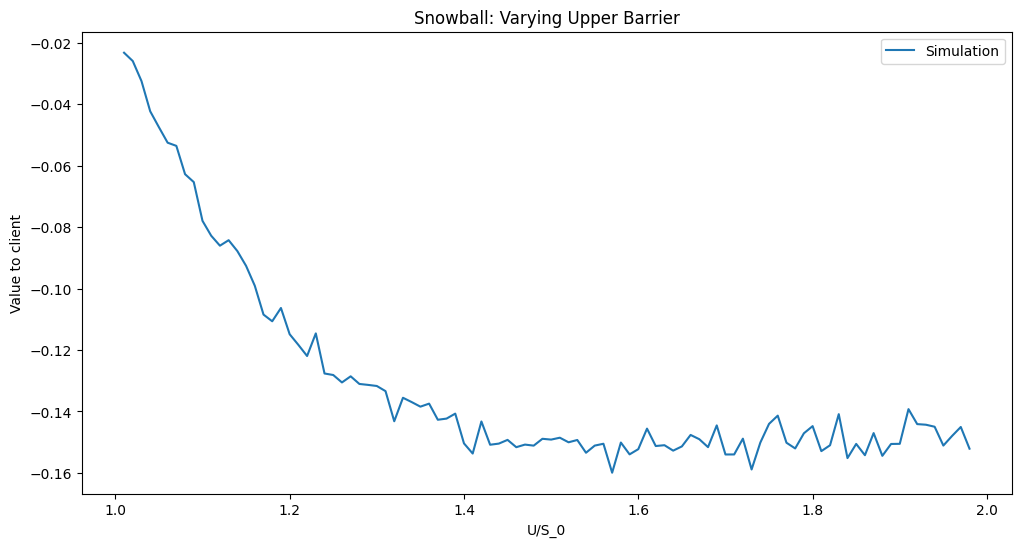

In [ ]:
# Normal Case with varying Upper Barrier U
S_0 = 50
sigma= 0.55
r = 0.04
T = 1
M = 1
L = 0.7 * S_0
y = 0.18
coef_list = np.arange(0.01,0.99,0.01)
sim_list = []
for coef in coef_list:
  H = (1+coef) *S_0
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(1+coef_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('U/S_0')
plt.title('Snowball: Varying Upper Barrier')
plt.show()

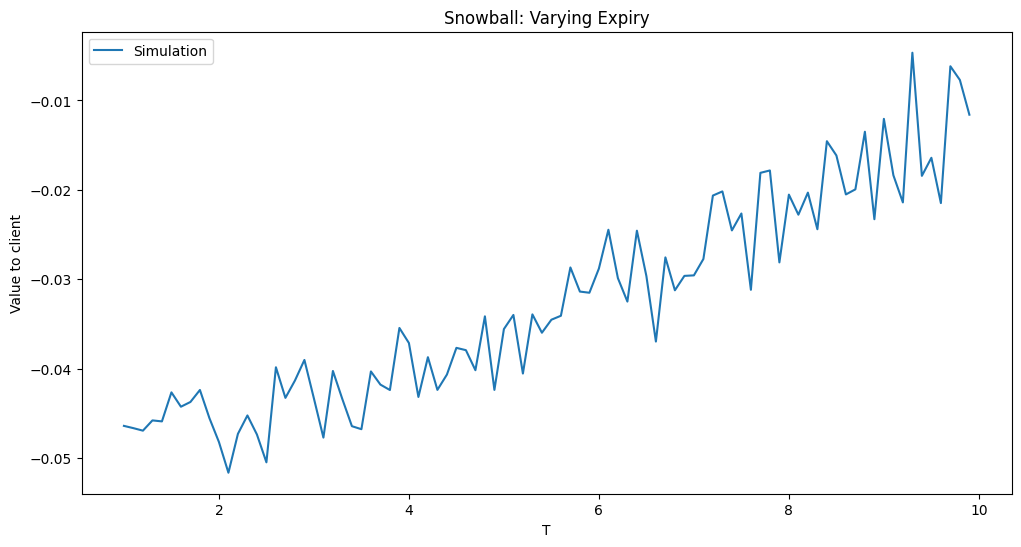

In [ ]:
# Normal Case with varying T
S_0 = 50
sigma= 0.55
r = 0.04
M = 1
L = 0.7 * S_0
H = 1.05 *S_0
y = 0.18
T_list = np.arange(1,10,0.1)
sim_list = []
for T in T_list:
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M,y))

plt.figure(figsize=(12,6))
plt.plot(T_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('T')
plt.title('Snowball: Varying Expiry')
plt.show()

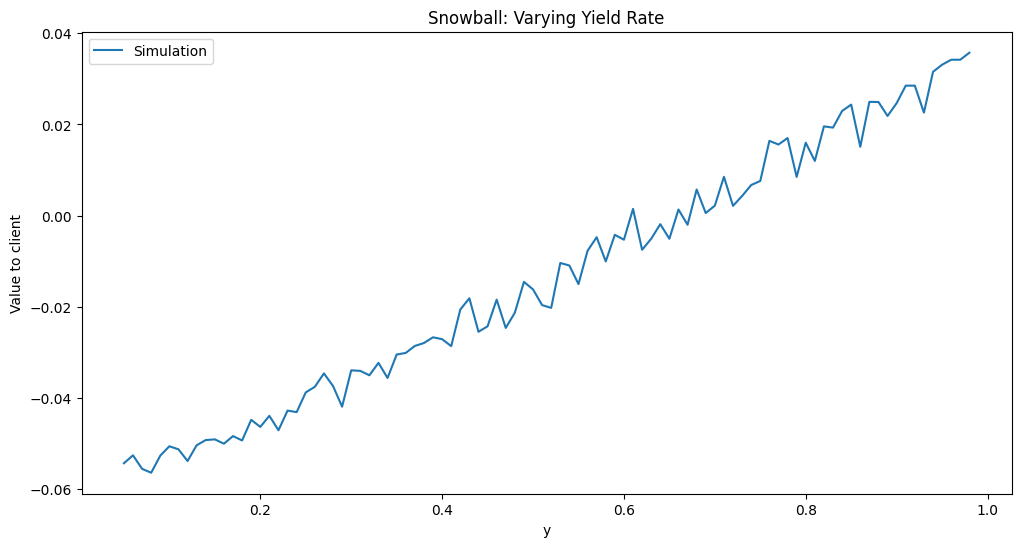

In [ ]:
# Normal Case with varying y
S_0 = 50
sigma= 0.55
r = 0.04
M = 1
T = 1
L = 0.7 * S_0
H = 1.05 *S_0
y_list = np.arange(0.05,0.99,0.01)
sim_list = []
for y in y_list:
  sim_list.append(simulation_snowball(252,5000,S_0, sigma,T,r,H,L,M, y))

plt.figure(figsize=(12,6))
plt.plot(y_list, sim_list, label = 'Simulation')
plt.legend()
plt.ylabel('Value to client')
plt.xlabel('y')
plt.title('Snowball: Varying Yield Rate')
plt.show()

# Greeks

## Delta

In [78]:
# calculate Delta
def snowball_delta(n,N,S_0, sigma,T,r,H,L,M,y, dS_0,round):
  delta = 0
  delta_list = []
  for num in range(round):
    dW = np.random.normal(0, np.sqrt(T/n), [N,n])
    S = np.zeros([N,n+1])


    # dS_0 = 0.01
    stock_path_left = np.zeros([N,n+1])
    stock_path_left[:,0] = [S_0-dS_0]*N
    stock_path_right = np.zeros([N,n+1])
    stock_path_right[:,0] = [S_0+dS_0]*N
    for i in range(n):
        stock_path_left[:,i+1] = stock_path_left[:,i] +mu*stock_path_left[:,i]*T/n +sigma * stock_path_left[:,i] * dW[:,i]
        stock_path_right[:,i+1] = stock_path_right[:,i] +mu*stock_path_right[:,i]*T/n +sigma * stock_path_right[:,i] * dW[:,i]

    path_df_1 = pd.DataFrame(stock_path_left)
    # find the knock-out date index, index of tau
    knock_out = (path_df_1>H).idxmax(axis =1 )
    # calculate the tau in years
    tau = knock_out[knock_out !=0] /n*T
    dis_payoff_out = M*(np.exp((y-r)*tau) -1 )
    # find no knock-in and no knock-out paths
    no_in_no_out = (~(((path_df_1<=L).any(axis=1))|((path_df_1>=H).any(axis=1)))).astype(int)
    dis_payoff_no_event = M*(np.exp((y-r)*T)-1)*no_in_no_out[no_in_no_out ==1]
    # find knock in and no knock out paths
    knock_in = path_df_1[((path_df_1<L).any(axis=1))&((path_df_1<H).all(axis=1))].iloc[:,-1]
    dis_payoff_in = -M/S_0 * knock_in.apply(lambda x: 0 if x>S_0 else S_0-x) *np.exp(-r*T) - M*(1-np.exp(-r*T))
    price_1 = (dis_payoff_out.sum()+dis_payoff_no_event.sum()+dis_payoff_in.sum())/N

    path_df_2 = pd.DataFrame(stock_path_right)
    # find the knock-out date index, index of tau
    knock_out = (path_df_2>H).idxmax(axis =1 )
    # calculate the tau in years
    tau = knock_out[knock_out !=0] /n*T
    dis_payoff_out = M*(np.exp((y-r)*tau) -1 )
    # find no knock-in and no knock-out paths
    no_in_no_out = (~(((path_df_2<=L).any(axis=1))|((path_df_2>=H).any(axis=1)))).astype(int)
    dis_payoff_no_event = M*(np.exp((y-r)*T)-1)*no_in_no_out[no_in_no_out ==1]
    # find knock in and no knock out paths
    knock_in = path_df_2[((path_df_2<L).any(axis=1))&((path_df_2<H).all(axis=1))].iloc[:,-1]
    dis_payoff_in = -M/S_0 * knock_in.apply(lambda x: 0 if x>S_0 else S_0-x) *np.exp(-r*T) - M*(1-np.exp(-r*T))
    price_2 = (dis_payoff_out.sum()+dis_payoff_no_event.sum()+dis_payoff_in.sum())/N

    MC_delta = (price_2-price_1)/(2*dS_0)
    # print('MC delta: ',MC_delta)
    delta_list.append(MC_delta)
    delta += MC_delta
  delta = delta/round
  return delta,delta_list


(array([ 53., 373., 112., 143.,  57.,  35.,  17.,   7.,   2.,   1.]),
 array([-0.01965872, -0.00559637,  0.00846597,  0.02252832,  0.03659067,
         0.05065301,  0.06471536,  0.0787777 ,  0.09284005,  0.10690239,
         0.12096474]),
 <BarContainer object of 10 artists>)

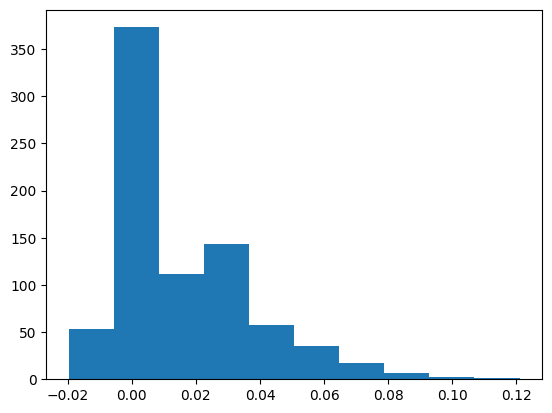

In [ ]:
S_0 = 50
sigma = 0.55
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05* S_0
y = 0.18
delta, delta_list1 = snowball_delta(252,1000,S_0, sigma,T,r,H,L,M,y,0.01,800)
plt.hist(delta_list1)

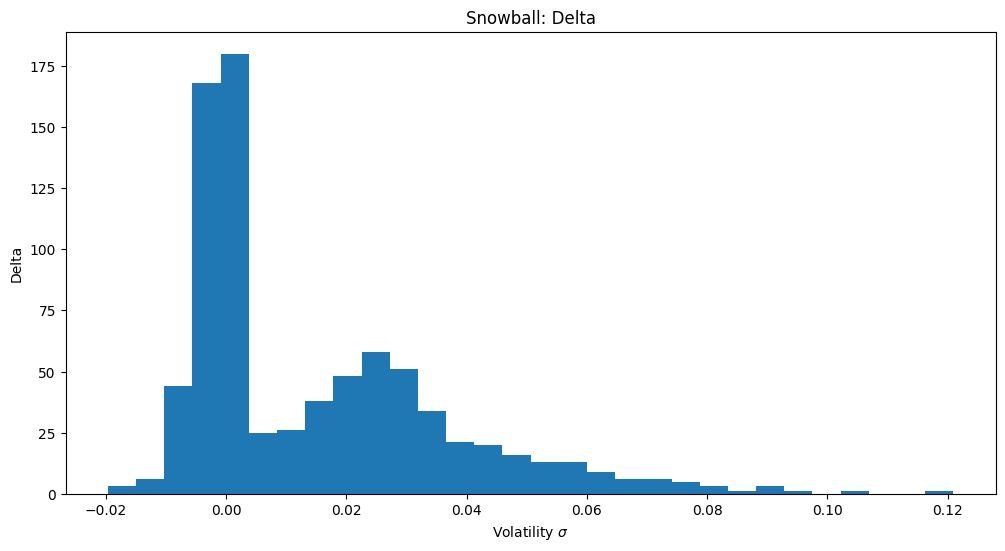

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(delta_list1, bins=30)
plt.ylabel('Delta')
plt.xlabel('Volatility $\sigma$')
plt.show()

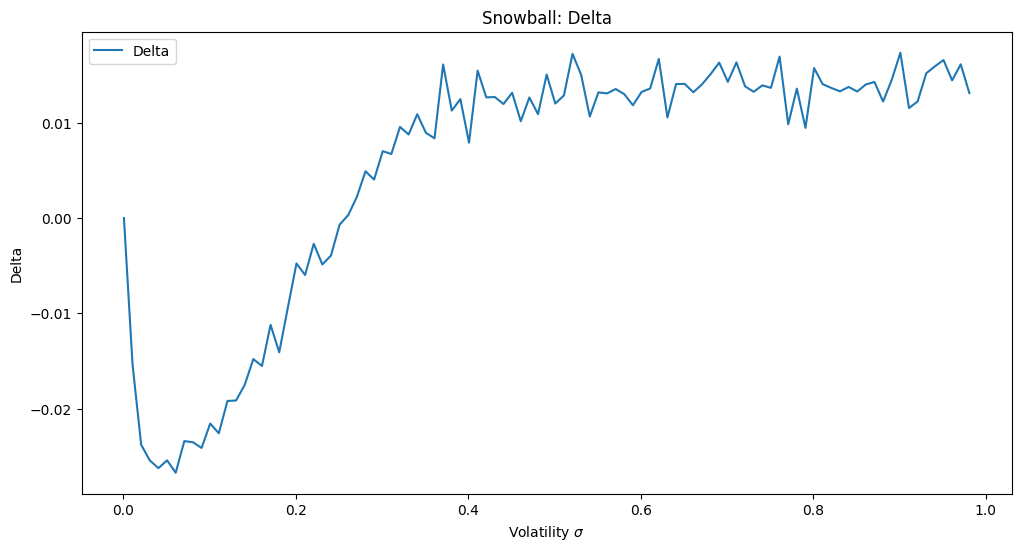

In [79]:
# plot delta against sigma
S_0 = 50
# sigma = 0.55
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05* S_0
y = 0.18
sig_list = np.arange(0.001,0.99,0.01)
delta_list = []
for sig in sig_list:
  delta, _ = snowball_delta(252,1000,S_0, sig,T,r,H,L,M,y,0.01,100)
  delta_list.append(delta)

plt.figure(figsize=(12,6))
plt.plot(sig_list, delta_list, label = 'Delta')
plt.legend()
plt.ylabel('Delta')
plt.xlabel('Volatility $\sigma$')
plt.title('Snowball: Delta')
plt.show()

## Vega

In [80]:
# calculate Vega
# np.random.seed(0)
def snowball_vega(n,N,S_0, sigma,T,r,H,L,M,y,dSig,round):
  vega = 0
  vega_list = []
  for num in range(round):
    dW = np.random.normal(0, np.sqrt(T/n), [N,n])
    S = np.zeros([N,n+1])

    # dSig = 0.01
    stock_path_left = np.zeros([N,n+1])
    stock_path_left[:,0] = [S_0]*N
    stock_path_right = np.zeros([N,n+1])
    stock_path_right[:,0] = [S_0]*N
    for i in range(n):
        stock_path_left[:,i+1] = stock_path_left[:,i] +mu*stock_path_left[:,i]*T/n +(sigma-dSig) * stock_path_left[:,i] * dW[:,i]
        stock_path_right[:,i+1] = stock_path_right[:,i] +mu*stock_path_right[:,i]*T/n +(sigma+dSig) * stock_path_right[:,i] * dW[:,i]

    path_df_1 = pd.DataFrame(stock_path_left)
    # find the knock-out date index, index of tau
    knock_out = (path_df_1>H).idxmax(axis =1 )
    # calculate the tau in years
    tau = knock_out[knock_out !=0] /n*T
    dis_payoff_out = M*(np.exp((y-r)*tau) -1 )
    # find no knock-in and no knock-out paths
    no_in_no_out = (~(((path_df_1<=L).any(axis=1))|((path_df_1>=H).any(axis=1)))).astype(int)
    dis_payoff_no_event = M*(np.exp((y-r)*T)-1)*no_in_no_out[no_in_no_out ==1]
    # find knock in and no knock out paths
    knock_in = path_df_1[((path_df_1<L).any(axis=1))&((path_df_1<H).all(axis=1))].iloc[:,-1]
    dis_payoff_in = -M/S_0 * knock_in.apply(lambda x: 0 if x>S_0 else S_0-x) *np.exp(-r*T) - M*(1-np.exp(-r*T))
    price_1 = (dis_payoff_out.sum()+dis_payoff_no_event.sum()+dis_payoff_in.sum())/N

    path_df_2 = pd.DataFrame(stock_path_right)
    # find the knock-out date index, index of tau
    knock_out = (path_df_2>H).idxmax(axis =1 )
    # calculate the tau in years
    tau = knock_out[knock_out !=0] /n*T
    dis_payoff_out = M*(np.exp((y-r)*tau) -1 )
    # find no knock-in and no knock-out paths
    no_in_no_out = (~(((path_df_2<=L).any(axis=1))|((path_df_2>=H).any(axis=1)))).astype(int)
    dis_payoff_no_event = M*(np.exp((y-r)*T)-1)*no_in_no_out[no_in_no_out ==1]
    # find knock in and no knock out paths
    knock_in = path_df_2[((path_df_2<L).any(axis=1))&((path_df_2<H).all(axis=1))].iloc[:,-1]
    dis_payoff_in = -M/S_0 * knock_in.apply(lambda x: 0 if x>S_0 else S_0-x) *np.exp(-r*T) - M*(1-np.exp(-r*T))
    price_2 = (dis_payoff_out.sum()+dis_payoff_no_event.sum()+dis_payoff_in.sum())/N

    MC_vega = (price_2-price_1)/(2*dSig)
    # print('MC delta: ',MC_vega)
    vega += MC_vega
    vega_list.append(MC_vega)
  vega = vega/round
  return vega, vega_list

In [81]:
S_0 = 50
sigma = 0.001
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05* S_0
y = 0.18


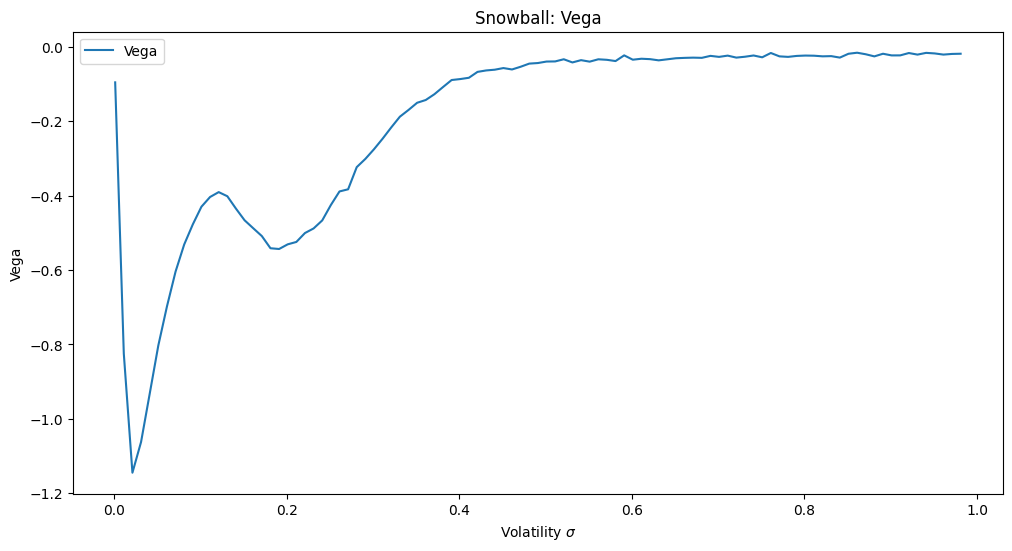

In [83]:
# plot vega against sigma
S_0 = 50
# sigma = 0.55
r = 0.04
T = 1
mu = r
M = 1
L = 0.7 * S_0
H = 1.05* S_0
y = 0.18
sig_list = np.arange(0.001,0.99,0.01)
vega_list = []
for sig in sig_list:
  vega, _ = snowball_vega(2520,1000,S_0, sig,T,r,H,L,M,y,0.01,100)
  vega_list.append(vega)

plt.figure(figsize=(12,6))
plt.plot(sig_list, vega_list, label = 'Vega')
plt.legend()
plt.ylabel('Vega')
plt.xlabel('Volatility $\sigma$')
plt.title('Snowball: Vega')
plt.show()

# Data & Hedging

In [3]:
# File path
file_path = '/content/CSI500_hist.csv'

# Read the CSV file into a DataFrame
csi_df = pd.read_csv(file_path)

# Assuming '日期' is the date column and '收盘价' is the close price column based on typical Chinese financial data naming conventions
# Convert the date column to datetime format
csi_df['日期'] = pd.to_datetime(csi_df['日期'], format='%Y-%m-%d')
csi_df.sort_index(inplace =True,ascending=False)
# Set the date column as the index
csi_df.set_index('日期', inplace=True)
csi_df.index.names = ['Date']
# Rename the closing price column to 'Close'
csi_df.columns = ['Close','Open', 'High','Low', 'Volume', 'Return']

# We need close price and return
csi_df['Close'] = csi_df['Close'].str.replace('[\$,]', '', regex=True)
csi_df['Close'] =csi_df['Close'].astype(float)
csi_df['Return'] = csi_df['Return'].str.replace('[\$,%]', '', regex=True)
csi_df['Return'] =csi_df['Return'].astype(float)*0.01

csi_data  =csi_df[['Close','Return']].copy()
csi_data.head()

,Close,Return
Date,,
2023-05-04,6262.39,0.0034
2023-05-05,6200.58,-0.0099
2023-05-08,6248.58,0.0077
2023-05-09,6181.98,-0.0107
2023-05-10,6173.81,-0.0013


In [11]:
# historical volatility around 0.2
hist_vol = csi_data['Return'].std()*np.sqrt(252)
hist_vol

0.19892559010445687

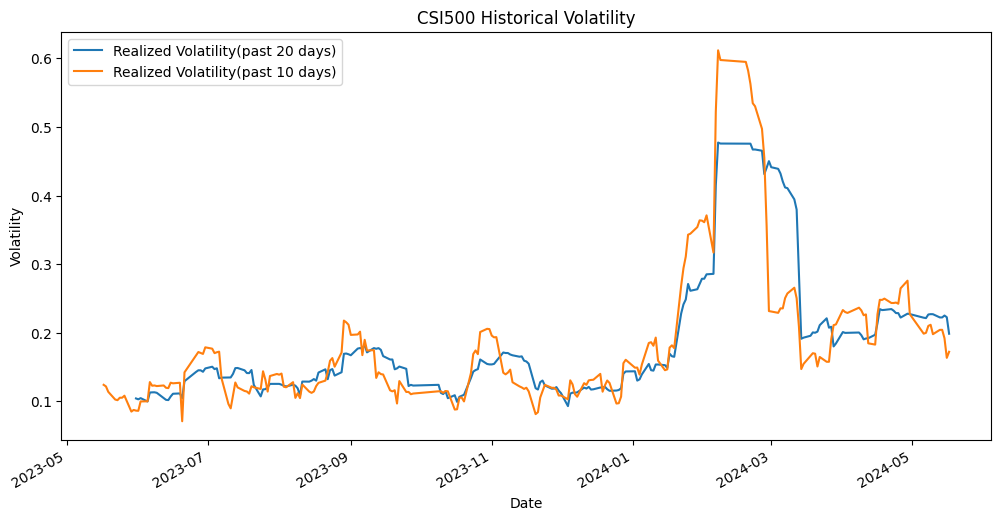

In [4]:
# rolling 20 day historial vol
csi_data['Volatility_20'] = csi_data['Return'].rolling(window=20).std() * np.sqrt(252)

# rolling 10 day historical vol
csi_data['Volatility_10'] = csi_data['Return'].rolling(window=10).std() * np.sqrt(252)
plt.figure(figsize=(12,6))
csi_data['Volatility_20'].plot(label = 'Realized Volatility(past 20 days)')
csi_data['Volatility_10'].plot(label = 'Realized Volatility(past 10 days)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('CSI500 Historical Volatility')
plt.show()

# Appendix: Payoff Plot

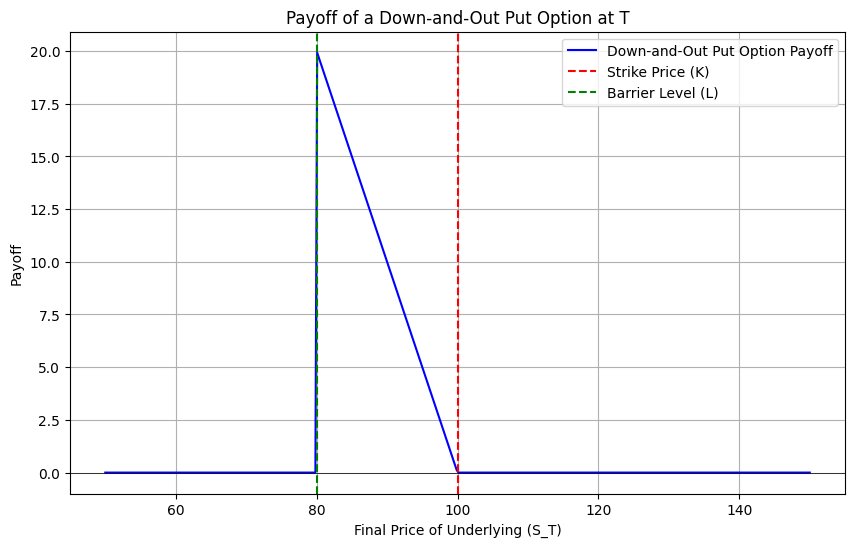

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
K = 100  # Strike price
L = 80   # Barrier level

# Generate a range of final prices
S_T = np.linspace(50, 150, 400)

# Calculate payoff
payoff = np.where(S_T > L, np.maximum(K - S_T, 0), 0)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Down-and-Out Put Option Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(K, color='r', linestyle='--', label='Strike Price (K)')
plt.axvline(L, color='g', linestyle='--', label='Barrier Level (L)')
plt.title('Payoff of a Down-and-Out Put Option at T')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


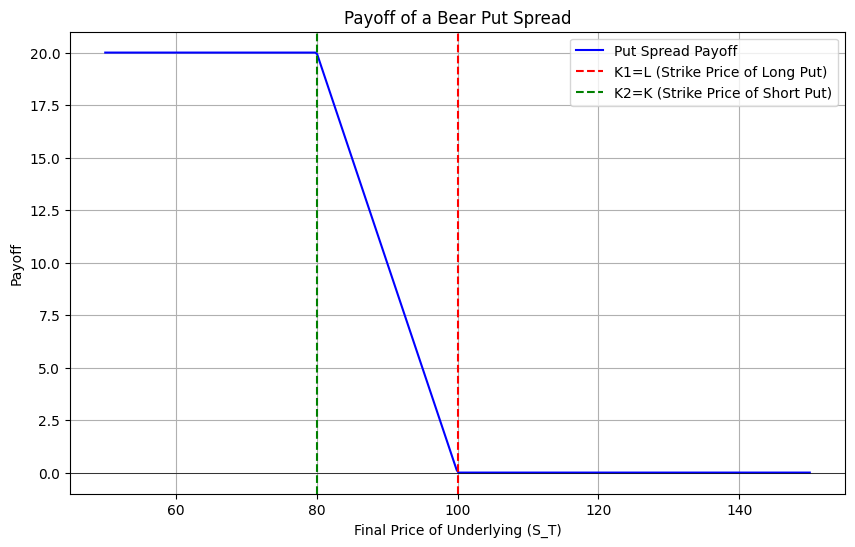

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
K1 = 100  # Strike price of long put
K2 = 80   # Strike price of short put

# Generate a range of final prices
S_T = np.linspace(50, 150, 400)

# Calculate payoff for the put spread
payoff = np.where(S_T > K1, 0, np.where(S_T > K2, K1 - S_T, K1 - K2))

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Put Spread Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(K1, color='r', linestyle='--', label='K1=L (Strike Price of Long Put)')
plt.axvline(K2, color='g', linestyle='--', label='K2=K (Strike Price of Short Put)')
plt.title('Payoff of a Bear Put Spread')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


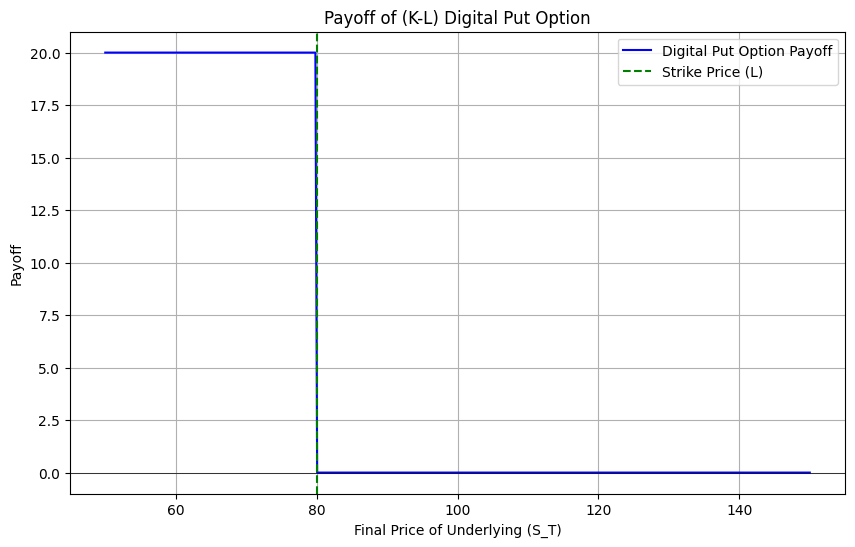

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 80  # Strike price (barrier level)

# Generate a range of final prices
S_T = np.linspace(50, 150, 400)

# Calculate payoff for the digital put
payoff = np.where(S_T < L, K-L, 0)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Digital Put Option Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(L, color='g', linestyle='--', label='Strike Price (L)')
plt.title('Payoff of (K-L) Digital Put Option')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


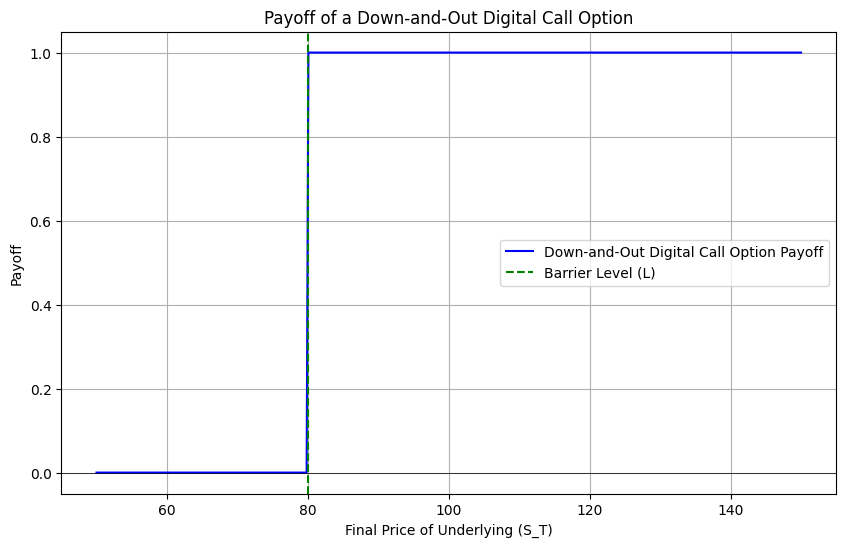

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 80  # Barrier level

# Generate a range of final prices
S_T = np.linspace(50, 150, 400)

# Calculate payoff for the down-and-out digital call
payoff = np.where(S_T > L, 1, 0)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Down-and-Out Digital Call Option Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(L, color='g', linestyle='--', label='Barrier Level (L)')
plt.title('Payoff of a Down-and-Out Digital Call Option')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


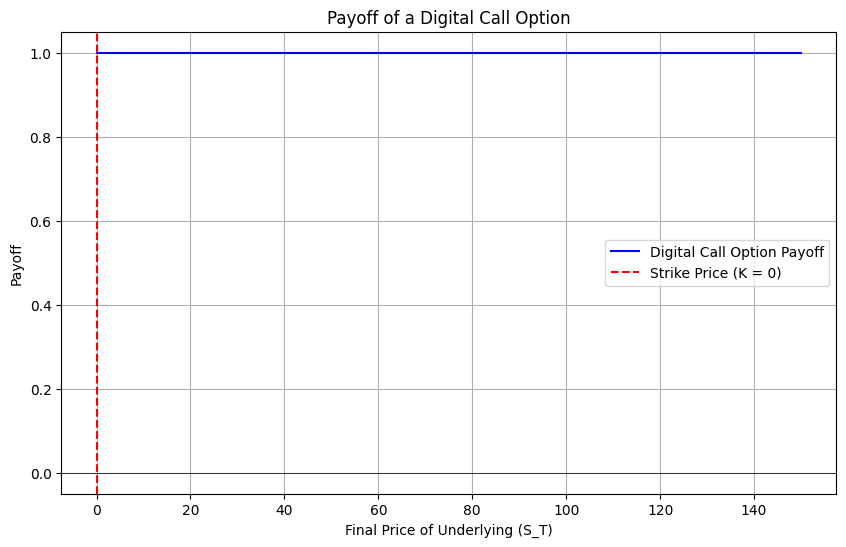

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
K = 0  # Strike price

# Generate a range of final prices
S_T = np.linspace(0, 150, 400)

# Calculate payoff for the digital call
payoff = np.ones_like(S_T)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Digital Call Option Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(K, color='r', linestyle='--', label='Strike Price (K = 0)')
plt.title('Payoff of a Digital Call Option')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


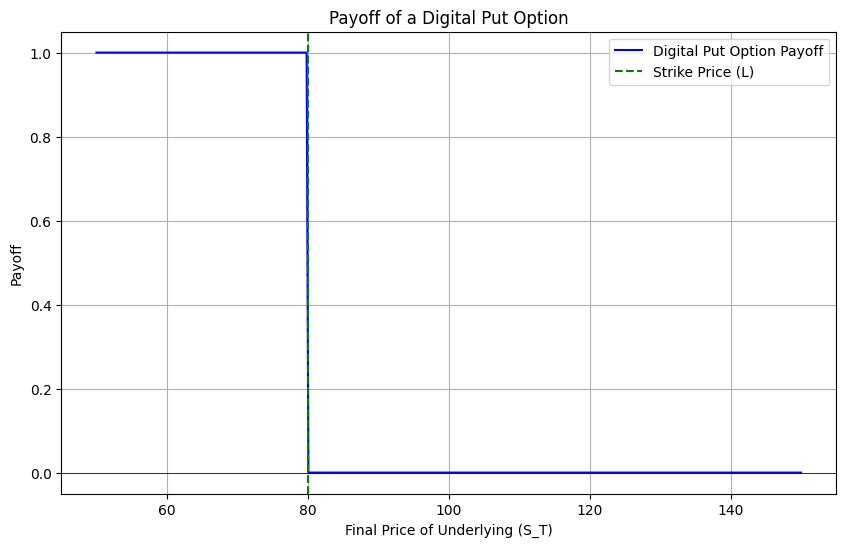

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 80  # Strike price

# Generate a range of final prices
S_T = np.linspace(50, 150, 400)

# Calculate payoff for the digital put
payoff = np.where(S_T < L, 1, 0)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(S_T, payoff, label='Digital Put Option Payoff', color='b')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(L, color='g', linestyle='--', label='Strike Price (L)')
plt.title('Payoff of a Digital Put Option')
plt.xlabel('Final Price of Underlying (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()
